In [1]:
import gc
import os

import pandas as pd
import numpy as np
import warnings
import pickle
import polars as pl

from collections import defaultdict
from itertools import combinations
import pyarrow as pa

from xgboost import XGBClassifier

# from lightgbm import LGBMClassifier
# from lightgbm import early_stopping
# from lightgbm import log_evaluation

from sklearn.model_selection import KFold

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve


import matplotlib.pyplot as plt
import seaborn as sns
# from colorama import Fore, Back, Style


from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE, RandomOverSampler

In [2]:

# Set max display options
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

# Data preprocessing

In [3]:
CATS = ['event_name', 'name', 'fqid', 'room_fqid', 'text_fqid']
NUMS = [
        'hover_duration', 'elapsed_time_diff','room_coor_diff', 'screen_coor_diff','room_coor_x', 'room_coor_y', 'screen_coor_x', 'screen_coor_y',] #'page', 'room_coor_x', 'room_coor_y', 'screen_coor_x', 'screen_coor_y',
fqid_lists = ['worker', 'archivist', 'gramps', 'wells', 'toentry', 'confrontation', 'crane_ranger', 'groupconvo', 'flag_girl', 'tomap', 'tostacks', 'tobasement', 'archivist_glasses', 'boss', 'journals', 'seescratches', 'groupconvo_flag', 'cs', 'teddy', 'expert', 'businesscards', 'ch3start', 'tunic.historicalsociety', 'tofrontdesk', 'savedteddy', 'plaque', 'glasses', 'tunic.drycleaner', 'reader_flag', 'tunic.library', 'tracks', 'tunic.capitol_2', 'trigger_scarf', 'reader', 'directory', 'tunic.capitol_1', 'journals.pic_0.next', 'unlockdoor', 'tunic', 'what_happened', 'tunic.kohlcenter', 'tunic.humanecology', 'colorbook', 'logbook', 'businesscards.card_0.next', 'journals.hub.topics', 'logbook.page.bingo', 'journals.pic_1.next', 'journals_flag', 'reader.paper0.next', 'tracks.hub.deer', 'reader_flag.paper0.next', 'trigger_coffee', 'wellsbadge', 'journals.pic_2.next', 'tomicrofiche', 'journals_flag.pic_0.bingo', 'plaque.face.date', 'notebook', 'tocloset_dirty', 'businesscards.card_bingo.bingo', 'businesscards.card_1.next', 'tunic.wildlife', 'tunic.hub.slip', 'tocage', 'journals.pic_2.bingo', 'tocollectionflag', 'tocollection', 'chap4_finale_c', 'chap2_finale_c', 'lockeddoor', 'journals_flag.hub.topics', 'tunic.capitol_0', 'reader_flag.paper2.bingo', 'photo', 'tunic.flaghouse', 'reader.paper1.next', 'directory.closeup.archivist', 'intro', 'businesscards.card_bingo.next', 'reader.paper2.bingo', 'retirement_letter', 'remove_cup', 'journals_flag.pic_0.next', 'magnify', 'coffee', 'key', 'togrampa', 'reader_flag.paper1.next', 'janitor', 'tohallway', 'chap1_finale', 'report', 'outtolunch', 'journals_flag.hub.topics_old', 'journals_flag.pic_1.next', 'reader.paper2.next', 'chap1_finale_c', 'reader_flag.paper2.next', 'door_block_talk', 'journals_flag.pic_1.bingo', 'journals_flag.pic_2.next', 'journals_flag.pic_2.bingo', 'block_magnify', 'reader.paper0.prev', 'block', 'reader_flag.paper0.prev', 'block_0', 'door_block_clean', 'reader.paper2.prev', 'reader.paper1.prev', 'doorblock', 'tocloset', 'reader_flag.paper2.prev', 'reader_flag.paper1.prev', 'block_tomap2', 'journals_flag.pic_0_old.next', 'journals_flag.pic_1_old.next', 'block_tocollection', 'block_nelson', 'journals_flag.pic_2_old.next', 'block_tomap1', 'block_badge', 'need_glasses', 'block_badge_2', 'fox', 'block_1']

name_feature = ['basic', 'undefined', 'close', 'open', 'prev', 'next']
event_name_feature = ['cutscene_click', 'person_click', 'navigate_click',
       'observation_click', 'notification_click', 'object_click',
       'object_hover', 'map_hover', 'map_click', 'checkpoint',
       'notebook_click']
text_lists = ['tunic.historicalsociety.cage.confrontation', 'tunic.wildlife.center.crane_ranger.crane', 'tunic.historicalsociety.frontdesk.archivist.newspaper', 'tunic.historicalsociety.entry.groupconvo', 'tunic.wildlife.center.wells.nodeer', 'tunic.historicalsociety.frontdesk.archivist.have_glass', 'tunic.drycleaner.frontdesk.worker.hub', 'tunic.historicalsociety.closet_dirty.gramps.news', 'tunic.humanecology.frontdesk.worker.intro', 'tunic.historicalsociety.frontdesk.archivist_glasses.confrontation', 'tunic.historicalsociety.basement.seescratches', 'tunic.historicalsociety.collection.cs', 'tunic.flaghouse.entry.flag_girl.hello', 'tunic.historicalsociety.collection.gramps.found', 'tunic.historicalsociety.basement.ch3start', 'tunic.historicalsociety.entry.groupconvo_flag', 'tunic.library.frontdesk.worker.hello', 'tunic.library.frontdesk.worker.wells', 'tunic.historicalsociety.collection_flag.gramps.flag', 'tunic.historicalsociety.basement.savedteddy', 'tunic.library.frontdesk.worker.nelson', 'tunic.wildlife.center.expert.removed_cup', 'tunic.library.frontdesk.worker.flag', 'tunic.historicalsociety.frontdesk.archivist.hello', 'tunic.historicalsociety.closet.gramps.intro_0_cs_0', 'tunic.historicalsociety.entry.boss.flag', 'tunic.flaghouse.entry.flag_girl.symbol', 'tunic.historicalsociety.closet_dirty.trigger_scarf', 'tunic.drycleaner.frontdesk.worker.done', 'tunic.historicalsociety.closet_dirty.what_happened', 'tunic.wildlife.center.wells.animals', 'tunic.historicalsociety.closet.teddy.intro_0_cs_0', 'tunic.historicalsociety.cage.glasses.afterteddy', 'tunic.historicalsociety.cage.teddy.trapped', 'tunic.historicalsociety.cage.unlockdoor', 'tunic.historicalsociety.stacks.journals.pic_2.bingo', 'tunic.historicalsociety.entry.wells.flag', 'tunic.humanecology.frontdesk.worker.badger', 'tunic.historicalsociety.stacks.journals_flag.pic_0.bingo', 'tunic.historicalsociety.closet.intro', 'tunic.historicalsociety.closet.retirement_letter.hub', 'tunic.historicalsociety.entry.directory.closeup.archivist', 'tunic.historicalsociety.collection.tunic.slip', 'tunic.kohlcenter.halloffame.plaque.face.date', 'tunic.historicalsociety.closet_dirty.trigger_coffee', 'tunic.drycleaner.frontdesk.logbook.page.bingo', 'tunic.library.microfiche.reader.paper2.bingo', 'tunic.kohlcenter.halloffame.togrampa', 'tunic.capitol_2.hall.boss.haveyougotit', 'tunic.wildlife.center.wells.nodeer_recap', 'tunic.historicalsociety.cage.glasses.beforeteddy', 'tunic.historicalsociety.closet_dirty.gramps.helpclean', 'tunic.wildlife.center.expert.recap', 'tunic.historicalsociety.frontdesk.archivist.have_glass_recap', 'tunic.historicalsociety.stacks.journals_flag.pic_1.bingo', 'tunic.historicalsociety.cage.lockeddoor', 'tunic.historicalsociety.stacks.journals_flag.pic_2.bingo', 'tunic.historicalsociety.collection.gramps.lost', 'tunic.historicalsociety.closet.notebook', 'tunic.historicalsociety.frontdesk.magnify', 'tunic.humanecology.frontdesk.businesscards.card_bingo.bingo', 'tunic.wildlife.center.remove_cup', 'tunic.library.frontdesk.wellsbadge.hub', 'tunic.wildlife.center.tracks.hub.deer', 'tunic.historicalsociety.frontdesk.key', 'tunic.library.microfiche.reader_flag.paper2.bingo', 'tunic.flaghouse.entry.colorbook', 'tunic.wildlife.center.coffee', 'tunic.capitol_1.hall.boss.haveyougotit', 'tunic.historicalsociety.basement.janitor', 'tunic.historicalsociety.collection_flag.gramps.recap', 'tunic.wildlife.center.wells.animals2', 'tunic.flaghouse.entry.flag_girl.symbol_recap', 'tunic.historicalsociety.closet_dirty.photo', 'tunic.historicalsociety.stacks.outtolunch', 'tunic.library.frontdesk.worker.wells_recap', 'tunic.historicalsociety.frontdesk.archivist_glasses.confrontation_recap', 'tunic.capitol_0.hall.boss.talktogramps', 'tunic.historicalsociety.closet.photo', 'tunic.historicalsociety.collection.tunic', 'tunic.historicalsociety.closet.teddy.intro_0_cs_5', 'tunic.historicalsociety.closet_dirty.gramps.archivist', 'tunic.historicalsociety.closet_dirty.door_block_talk', 'tunic.historicalsociety.entry.boss.flag_recap', 'tunic.historicalsociety.frontdesk.archivist.need_glass_0', 'tunic.historicalsociety.entry.wells.talktogramps', 'tunic.historicalsociety.frontdesk.block_magnify', 'tunic.historicalsociety.frontdesk.archivist.foundtheodora', 'tunic.historicalsociety.closet_dirty.gramps.nothing', 'tunic.historicalsociety.closet_dirty.door_block_clean', 'tunic.capitol_1.hall.boss.writeitup', 'tunic.library.frontdesk.worker.nelson_recap', 'tunic.library.frontdesk.worker.hello_short', 'tunic.historicalsociety.stacks.block', 'tunic.historicalsociety.frontdesk.archivist.need_glass_1', 'tunic.historicalsociety.entry.boss.talktogramps', 'tunic.historicalsociety.frontdesk.archivist.newspaper_recap', 'tunic.historicalsociety.entry.wells.flag_recap', 'tunic.drycleaner.frontdesk.worker.done2', 'tunic.library.frontdesk.worker.flag_recap', 'tunic.humanecology.frontdesk.block_0', 'tunic.library.frontdesk.worker.preflag', 'tunic.historicalsociety.basement.gramps.seeyalater', 'tunic.flaghouse.entry.flag_girl.hello_recap', 'tunic.historicalsociety.closet.doorblock', 'tunic.drycleaner.frontdesk.worker.takealook', 'tunic.historicalsociety.basement.gramps.whatdo', 'tunic.library.frontdesk.worker.droppedbadge', 'tunic.historicalsociety.entry.block_tomap2', 'tunic.library.frontdesk.block_nelson', 'tunic.library.microfiche.block_0', 'tunic.historicalsociety.entry.block_tocollection', 'tunic.historicalsociety.entry.block_tomap1', 'tunic.historicalsociety.collection.gramps.look_0', 'tunic.library.frontdesk.block_badge', 'tunic.historicalsociety.cage.need_glasses', 'tunic.library.frontdesk.block_badge_2', 'tunic.kohlcenter.halloffame.block_0', 'tunic.capitol_0.hall.chap1_finale_c', 'tunic.capitol_1.hall.chap2_finale_c', 'tunic.capitol_2.hall.chap4_finale_c', 'tunic.wildlife.center.fox.concern', 'tunic.drycleaner.frontdesk.block_0', 'tunic.historicalsociety.entry.gramps.hub', 'tunic.humanecology.frontdesk.block_1', 'tunic.drycleaner.frontdesk.block_1']
room_lists = ['tunic.historicalsociety.entry', 'tunic.wildlife.center', 'tunic.historicalsociety.cage', 'tunic.library.frontdesk', 'tunic.historicalsociety.frontdesk', 'tunic.historicalsociety.stacks', 'tunic.historicalsociety.closet_dirty', 'tunic.humanecology.frontdesk', 'tunic.historicalsociety.basement', 'tunic.kohlcenter.halloffame', 'tunic.library.microfiche', 'tunic.drycleaner.frontdesk', 'tunic.historicalsociety.collection', 'tunic.historicalsociety.closet', 'tunic.flaghouse.entry', 'tunic.historicalsociety.collection_flag', 'tunic.capitol_1.hall', 'tunic.capitol_0.hall', 'tunic.capitol_2.hall']

LEVELS = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
level_groups = ["0-4", "5-12", "13-22"]

In [4]:
columns = [

    #pl.col("page").cast(pl.Float32),
    (
        (pl.col("elapsed_time") - pl.col("elapsed_time").shift(1)) 
         .fill_null(0)
         .clip(0, 1e9)
         .over(["session_id", "level_group"])
         .alias("elapsed_time_diff")
    ),
    # (
    #     (pl.col("screen_coor_x") - pl.col("screen_coor_x").shift(1)) 
    #      .abs()
    #      .over(["session_id", "level_group"])
    #     .alias("location_x_diff") 
    # ),
    # (
    #     (pl.col("screen_coor_y") - pl.col("screen_coor_y").shift(1)) 
    #      .abs()
    #      .over(["session_id", "level_group"])
    #     .alias("location_y_diff") 
    # ),
    (
        ((pl.col("screen_coor_x") - pl.col("screen_coor_x").shift(1)) ** 2 
        + (pl.col("screen_coor_y") - pl.col("screen_coor_y").shift(1)) ** 2)
        .sqrt()
        .over(["session_id", "level_group"])
        .alias("screen_coor_diff")
    ),
    (
        ((pl.col("room_coor_x") - pl.col("room_coor_x").shift(1)) ** 2 
        + (pl.col("room_coor_y") - pl.col("room_coor_y").shift(1)) ** 2)
        .sqrt()
        .over(["session_id", "level_group"])
        .alias("room_coor_diff")
    ),
    pl.col("fqid").fill_null("fqid_None"),
    pl.col("text_fqid").fill_null("text_fqid_None")
]

In [5]:
%%time

# we prepare the dataset for the training by level :
df = (pl.read_csv("data/predict-student-performance-from-game-play/train.csv")
      .drop(["fullscreen", "hq", "music","page"])
      .with_columns(columns))

# df1 = df.filter(pl.col("level_group")=='0-4')
# df2 = df.filter(pl.col("level_group")=='5-12')
# df3 = df.filter(pl.col("level_group")=='13-22')
# df1.shape,df2.shape,df3.shape

CPU times: user 20.8 s, sys: 16.7 s, total: 37.4 s
Wall time: 8.77 s


# Old Gen

# New feature gen

In [30]:
def create_aggregations(column, conditions, stats, feature_suffix):
    aggs = []
    filtered_column = pl.col(column).filter(conditions)
    for stat in stats:
        if stat == 'count':
            aggs.append(filtered_column.count().alias(f"{column}_count_{feature_suffix}"))
        elif stat == 'mean':
            aggs.append(filtered_column.mean().alias(f"{column}_mean_{feature_suffix}"))
        elif stat == 'median':
            aggs.append(filtered_column.median().alias(f"{column}_median_{feature_suffix}"))
        elif stat == 'std':
            aggs.append(filtered_column.std().alias(f"{column}_std_{feature_suffix}"))
        elif stat == 'min':
            aggs.append(filtered_column.min().alias(f"{column}_min_{feature_suffix}"))
        elif stat == 'max':
            aggs.append(filtered_column.max().alias(f"{column}_max_{feature_suffix}"))
        elif stat == 'sum':
            aggs.append(filtered_column.sum().alias(f"{column}_sum_{feature_suffix}"))
    return aggs

def feature_engineer(x, grp, use_extra, feature_suffix):
    stats = ['count', 'mean', 'std', 'min', 'max', 'sum']

        # Select the data based on 'level_group'
    if grp == '0-4':
        df = x.filter(pl.col("level_group") == '0-4')
    elif grp == '5-12':
        df = x.filter(pl.col("level_group") == '5-12')
    elif grp == '13-22':
        df = x.filter(pl.col("level_group") == '13-22')
    else:
        raise ValueError("Invalid level group. Please select from ['0-4', '5-12', '13-22']")

    aggs = [
        pl.col("index").count().alias(f"session_number_{feature_suffix}"),
        *[pl.col(c).drop_nulls().n_unique().alias(f"{c}_unique_{feature_suffix}") for c in CATS],
        *[pl.col(c).std().alias(f"{c}_std_{feature_suffix}") for c in NUMS],
        *[pl.col(c).mean().alias(f"{c}_mean_{feature_suffix}") for c in NUMS],
        *[pl.col(c).median().alias(f"{c}_median_{feature_suffix}") for c in NUMS],
        *[pl.col(c).min().alias(f"{c}_min_{feature_suffix}") for c in NUMS],
        *[pl.col(c).max().alias(f"{c}_max_{feature_suffix}") for c in NUMS],
        *[pl.col(c).sum().alias(f"{c}_sum_{feature_suffix}") for c in NUMS]
    ]



    for feature_list, column_name in [(fqid_lists, "fqid"), #(text_lists, "text_fqid"), (room_lists, "room_fqid"),
                                      (LEVELS, "level"),(level_groups, "level_group"),  #(event_name_feature, "event_name"), (name_feature, "name"), 
                                      ]: #
        for c in feature_list:
            conditions = pl.col(column_name) == c
            aggs.extend(create_aggregations("elapsed_time_diff", conditions, stats, f"{c}_{feature_suffix}"))


    # Special case for level and room_lists
    for c in LEVELS:
        for d in room_lists:
            conditions = (pl.col("level") == c) & (pl.col("room_fqid") == d)
            aggs.append(pl.col("index").filter(conditions).count().alias(f"{c}{d}_level_room_count{feature_suffix}"))

    df = df.groupby(['session_id'], maintain_order=True).agg(aggs).sort("session_id")

    # df_pivot = df.pivot(
    # index='session_id',
    # columns='level',
    # values= [col for col in df.columns if col not in ['session_id', 'level']],
    # aggregate_function = None,
    # maintain_order = True,
    # separator = '_'
    # )


    return df.to_pandas()

In [9]:
%%time
df1_features = feature_engineer(df, grp='0-4', use_extra=False, feature_suffix='_')
print('df1_features done',df1_features.shape)
df2_features = feature_engineer(df, grp='5-12', use_extra=False, feature_suffix='_')
print('df2_features done',df2_features.shape)
df3_features = feature_engineer(df, grp='13-22', use_extra=False, feature_suffix='_')
print('df3_features done',df3_features.shape)

df1_features done (23562, 1385)
df2_features done (23562, 1385)
df3_features done (23562, 1385)
CPU times: user 3min 26s, sys: 14.3 s, total: 3min 40s
Wall time: 14.2 s


# Saving the data

In [10]:
# df1.to_parquet('df1.parquet')
# df2.to_parquet('df2.parquet')
# df3.to_parquet('df3.parquet')

# Cleaning the data

In [10]:
# some cleaning...
null1 = df1_features.isnull().sum().sort_values(ascending=False) / len(df1_features)
print(null1)
null2 = df2_features.isnull().sum().sort_values(ascending=False) / len(df2_features)
print(null2)
null3 = df3_features.isnull().sum().sort_values(ascending=False) / len(df3_features)
print(null3)

drop1 = list(null1[null1>0.5].index)
drop2 = list(null2[null2>0.5].index)
drop3 = list(null3[null3>0.5].index)
print(len(drop1), len(drop2), len(drop3))

for col in df1_features.columns:
    if df1_features[col].nunique()==1:
        print(col)
        drop1.append(col)
print("*********df1 DONE*********")
for col in df2_features.columns:
    if df2_features[col].nunique()==1:
        print(col)
        drop2.append(col)
print("*********df2 DONE*********")
for col in df3_features.columns:
    if df3_features[col].nunique()==1:
        print(col)
        drop3.append(col)
print("*********df3 DONE*********")


df1_features = df1_features.set_index('session_id')
df2_features = df2_features.set_index('session_id')
df3_features = df3_features.set_index('session_id')

FEATURES1 = [c for c in df1_features.columns if c not in drop1+['level_group']]
FEATURES2 = [c for c in df2_features.columns if c not in drop2+['level_group']]
FEATURES3 = [c for c in df3_features.columns if c not in drop3+['level_group']]
print('We will train with', len(FEATURES1), len(FEATURES2), len(FEATURES3) ,'features')
ALL_USERS = df1_features.index.unique()
print('We will train with', len(ALL_USERS) ,'users info')

elapsed_time_diff_mean_reader_flag.paper0.prev__    1.0
elapsed_time_diff_std_key__                         1.0
elapsed_time_diff_min_magnify__                     1.0
elapsed_time_diff_max_magnify__                     1.0
elapsed_time_diff_sum_magnify__                     1.0
                                                   ... 
elapsed_time_diff_min_2__                           0.0
elapsed_time_diff_max_2__                           0.0
elapsed_time_diff_sum_2__                           0.0
elapsed_time_diff_count_3__                         0.0
22tunic.capitol_2.hall_level_room_count_            0.0
Length: 1385, dtype: float64
elapsed_time_diff_mean_reader_flag.paper0.prev__    1.0
elapsed_time_diff_mean_reader_flag.paper2.next__    1.0
elapsed_time_diff_sum_journals_flag__               1.0
elapsed_time_diff_max_journals_flag__               1.0
elapsed_time_diff_min_journals_flag__               1.0
                                                   ... 
elapsed_time_diff_m

In [11]:
df1_features[FEATURES1]

,session_number__,event_name_unique__,name_unique__,fqid_unique__,room_fqid_unique__,text_fqid_unique__,hover_duration_std__,elapsed_time_diff_std__,room_coor_diff_std__,screen_coor_diff_std__,room_coor_x_std__,room_coor_y_std__,screen_coor_x_std__,screen_coor_y_std__,hover_duration_mean__,elapsed_time_diff_mean__,room_coor_diff_mean__,screen_coor_diff_mean__,room_coor_x_mean__,room_coor_y_mean__,screen_coor_x_mean__,screen_coor_y_mean__,hover_duration_median__,elapsed_time_diff_median__,room_coor_diff_median__,screen_coor_diff_median__,room_coor_x_median__,room_coor_y_median__,screen_coor_x_median__,screen_coor_y_median__,hover_duration_min__,room_coor_diff_min__,screen_coor_diff_min__,room_coor_x_min__,room_coor_y_min__,screen_coor_x_min__,screen_coor_y_min__,hover_duration_max__,elapsed_time_diff_max__,room_coor_diff_max__,screen_coor_diff_max__,room_coor_x_max__,room_coor_y_max__,screen_coor_x_max__,screen_coor_y_max__,hover_duration_sum__,elapsed_time_diff_sum__,room_coor_diff_sum__,screen_coor_diff_sum__,room_coor_x_sum__,room_coor_y_sum__,screen_coor_x_sum__,screen_coor_y_sum__,elapsed_time_diff_count_gramps__,elapsed_time_diff_mean_gramps__,elapsed_time_diff_std_gramps__,elapsed_time_diff_min_gramps__,elapsed_time_diff_max_gramps__,elapsed_time_diff_sum_gramps__,elapsed_time_diff_count_wells__,elapsed_time_diff_count_toentry__,elapsed_time_diff_mean_toentry__,elapsed_time_diff_std_toentry__,elapsed_time_diff_min_toentry__,elapsed_time_diff_max_toentry__,elapsed_time_diff_sum_toentry__,elapsed_time_diff_count_groupconvo__,elapsed_time_diff_mean_groupconvo__,elapsed_time_diff_std_groupconvo__,elapsed_time_diff_min_groupconvo__,elapsed_time_diff_max_groupconvo__,elapsed_time_diff_sum_groupconvo__,elapsed_time_diff_count_tomap__,elapsed_time_diff_mean_tomap__,elapsed_time_diff_std_tomap__,elapsed_time_diff_min_tomap__,elapsed_time_diff_max_tomap__,elapsed_time_diff_sum_tomap__,elapsed_time_diff_count_tostacks__,elapsed_time_diff_mean_tostacks__,elapsed_time_diff_std_tostacks__,elapsed_time_diff_min_tostacks__,elapsed_time_diff_max_tostacks__,elapsed_time_diff_sum_tostacks__,elapsed_time_diff_count_tobasement__,elapsed_time_diff_mean_tobasement__,elapsed_time_diff_std_tobasement__,elapsed_time_diff_min_tobasement__,elapsed_time_diff_max_tobasement__,elapsed_time_diff_sum_tobasement__,elapsed_time_diff_count_boss__,elapsed_time_diff_count_cs__,elapsed_time_diff_mean_cs__,elapsed_time_diff_std_cs__,elapsed_time_diff_min_cs__,elapsed_time_diff_max_cs__,elapsed_time_diff_sum_cs__,elapsed_time_diff_count_teddy__,elapsed_time_diff_mean_teddy__,elapsed_time_diff_std_teddy__,elapsed_time_diff_min_teddy__,elapsed_time_diff_max_teddy__,elapsed_time_diff_sum_teddy__,elapsed_time_diff_count_tunic.historicalsociety__,elapsed_time_diff_count_plaque__,elapsed_time_diff_mean_plaque__,elapsed_time_diff_std_plaque__,elapsed_time_diff_min_plaque__,elapsed_time_diff_max_plaque__,elapsed_time_diff_sum_plaque__,elapsed_time_diff_count_directory__,elapsed_time_diff_count_tunic__,elapsed_time_diff_mean_tunic__,elapsed_time_diff_std_tunic__,elapsed_time_diff_min_tunic__,elapsed_time_diff_max_tunic__,elapsed_time_diff_sum_tunic__,elapsed_time_diff_count_tunic.kohlcenter__,elapsed_time_diff_mean_tunic.kohlcenter__,elapsed_time_diff_std_tunic.kohlcenter__,elapsed_time_diff_min_tunic.kohlcenter__,elapsed_time_diff_max_tunic.kohlcenter__,elapsed_time_diff_sum_tunic.kohlcenter__,elapsed_time_diff_count_plaque.face.date__,elapsed_time_diff_mean_plaque.face.date__,elapsed_time_diff_std_plaque.face.date__,elapsed_time_diff_min_plaque.face.date__,elapsed_time_diff_max_plaque.face.date__,elapsed_time_diff_sum_plaque.face.date__,elapsed_time_diff_count_notebook__,elapsed_time_diff_mean_notebook__,elapsed_time_diff_std_notebook__,elapsed_time_diff_min_notebook__,elapsed_time_diff_max_notebook__,elapsed_time_diff_sum_notebook__,elapsed_time_diff_count_tunic.hub.slip__,elapsed_time_diff_mean_tunic.hub.slip__,elapsed_time_diff_std_tunic.hub.slip__,elapsed_time_dif

In [22]:
# Saving the lists to a file
with open('XG_boost_models/230611/features_lists.pkl', 'wb') as f:
    pickle.dump({'FEATURES1': FEATURES1, 'FEATURES2': FEATURES2, 'FEATURES3': FEATURES3}, f)

### Grid Search

In [13]:


warnings.filterwarnings("ignore")
targets = pd.read_csv('data/predict-student-performance-from-game-play/train_labels.csv')
targets['session'] = targets.session_id.apply(lambda x: int(x.split('_')[0]))
targets['q'] = targets.session_id.apply(lambda x: int(x.split('_')[-1][1:]))
pred_xgb = np.zeros((df1.shape[0],18))   

best_params_dict = {}

for t in range(1,19):
    # USE THIS TRAIN DATA WITH THESE QUESTIONS
    if t<=3: 
        grp = '0-4'
        df = df1_features
        FEATURES = FEATURES1

    elif t<=13: 
        grp = '5-12'
        df = df2_features
        FEATURES = FEATURES2

    elif t<=22: 
        grp = '13-22'
        df = df3_features
        FEATURES = FEATURES3
    
    # TRAIN DATA
    train_users = df.index.values
    train_y = targets.loc[targets.q==t].set_index('session').loc[train_users]



    # Define the parameter grid
    param_grid = {
        #'tree_method': ['gpu_hist'],  
        #'predictor': ['gpu_predictor'],
        'n_estimators': [250, ],  #300, 350, 400, 450, 500
        'learning_rate': [ 0.02, 0.05], # 0.05
        'max_depth': [4, 5, 6], #3, 4, 5
        'subsample': [0.8], #0.6, 0.8, 
        'colsample_bytree': [0.7], #, 0.5, 0.6
        'alpha': [6,8,10], #6, 8, 10
        #'scale_pos_weight': [1.0, scale_pos_weight,] #
    }

    # Initialize the estimator
    xgb_estimator = XGBClassifier(
        booster='gbtree',
        tree_method='hist',
        objective='binary:logistic',
        eval_metric='logloss',
        seed=42
        
    )

    # Initialize GridSearchCV
    grid_search = GridSearchCV(
        estimator=xgb_estimator,
        param_grid=param_grid,
        cv=5,  # Adjust the number of folds to your needs
        scoring='roc_auc',  # Adjust the scoring parameter to your needs
        verbose=1,
        n_jobs=-1  # Use all available CPU cores
    )

    X_train = df[FEATURES].astype('float32').fillna(-1)
    y_train = train_y['correct']

    # Use RandomOverSampler instead of SMOTE
    oversampler = RandomOverSampler(random_state=42)
    X_train, y_train = oversampler.fit_resample(X_train, y_train)

    # # Calculating class weights
    # num_neg = sum(train_y['correct'] == 0)
    # num_pos = sum(train_y['correct'] == 1)
    # scale_pos_weight = num_neg / num_pos

    # smote = SMOTE(random_state=42)
    # X_train = df[FEATURES].astype('float32').fillna(-1)
    # X_train, y_train = smote.fit_resample(X_train, train_y['correct'])

    # Fit GridSearchCV using the balanced dataset
    grid_search.fit(X_train, y_train)


    # Get the best parameters
    best_params = grid_search.best_params_

    # Save the best parameters
    best_params_dict[t] = best_params


    # # Variables
    # X_train = df[FEATURES].astype('float32')
    # #X_val = df_valid[FEATURES].astype('float32')
    # y_train = train_y['correct']
    # #y_val = valid_y['correct']

    # Calculate performance metrics on a validation set
    # Assuming you have a validation set split already: X_val, y_val
    y_pred = grid_search.predict(X_train)
    y_proba = grid_search.predict_proba(X_train)[:, 1]

    f1 = f1_score(y_train, y_pred)
    auc = roc_auc_score(y_train, y_proba)
    accuracy = accuracy_score(y_train, y_pred)

    print(f'Best parameters for question {t}: {best_params}')
    print(f'F1 score: {f1}, AUC score: {auc}, Accuracy: {accuracy}')

    

# Save best parameters to a file
with open('best_params.pkl', 'wb') as f:
    pickle.dump(best_params_dict, f)




NameError: name 'df1' is not defined

In [14]:
best_params_dict

{}

# Validation

## We fit and store the models for predictions

In [14]:
# # With previous training notebook (Kfold with 20 folds as performed in others notebooks) :
# estimators_xgb = [498, 448, 378, 364, 405, 495, 456, 249, 384, 405, 356, 262, 484, 381, 392, 350 ,248, 345]

# xgb_params = {
#         'booster': 'gbtree',
#         'tree_method': 'hist',
#         'objective': 'binary:logistic',
#         'eval_metric':'logloss',
#         'learning_rate': 0.02,
#         'alpha': 8,
#         'max_depth': 5,
#         'subsample':0.8,
#         'colsample_bytree': 0.5,
#         'seed': 42
#         }

xgb_params = {
    'booster': 'gbtree',
    'tree_method': 'hist',
    'objective': 'binary:logistic',
    'eval_metric':'logloss',
    "objective": "binary:logistic",
    "n_estimators": 400, # Increased because of decreased learning rate
    "max_depth": 6, # Reduced max_depth
    "min_child_weight": 5, # Increased min_child_weight
    "learning_rate": 0.05, # Reduced learning_rate
    "subsample": 0.8,
    "colsample_bytree": 0.5, # Reduced colsample_bytree
    "colsample_bylevel": 0.5, # Reduced colsample_bylevel
    "scale_pos_weight": 1,
    "lambda": 2, # Increased lambda
    "alpha": 20, # Increased alpha
    "n_jobs": -1,
    "random_state": 42
}


In [ ]:
# from sklearn.model_selection import StratifiedKFold
# import numpy as np

# num_folds = 20
# skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# best_thresholds = []

# # X and y should be your features and labels
# for train_index, val_index in skf.split(X, y):
#     X_train, X_val = X[train_index], X[val_index]
#     y_train, y_val = y[train_index], y[val_index]

#     # Your training code here
#     # ...

#     # Predict probabilities
#     y_scores = model.predict_proba(X_val)[:, 1]

#     # Calculate precision-recall values for different thresholds
#     precisions, recalls, thresholds = precision_recall_curve(y_val, y_scores)

#     # Calculate F1 score for each threshold
#     f1_scores = 2 * recalls * precisions / (recalls + precisions)

#     # Locate the index of the largest F1 score
#     best_index = np.argmax(f1_scores)

#     # Store the best threshold
#     best_thresholds.append(thresholds[best_index])

# # Choose the threshold that has the highest average F1 score
# best_threshold = np.mean(best_thresholds)

# # Retrain your model with all data here
# # ...

In [26]:
import random

def split_dataset(dataset, test_ratio=0.20):
    USER_LIST = list(dataset.index.unique())
    random.shuffle(USER_LIST)  # This line adds randomness to your split
    split = int(len(USER_LIST) * (1 - test_ratio))
    return dataset.loc[USER_LIST[:split]], dataset.loc[USER_LIST[split:]]

In [27]:
df1_train, df1_valid = split_dataset(df1_features)
print("{} examples in training, {} examples in testing.".format(
    len(df1_train), len(df1_valid)))

df2_train, df2_valid = split_dataset(df2_features)
print("{} examples in training, {} examples in testing.".format(
    len(df2_train), len(df2_valid)))

df3_train, df3_valid = split_dataset(df3_features)
print("{} examples in training, {} examples in testing.".format(
    len(df3_train), len(df3_valid)))

18849 examples in training, 4713 examples in testing.
18849 examples in training, 4713 examples in testing.
18849 examples in training, 4713 examples in testing.


XGB model evaluation for question 1
####################################
Training F1 Score: 0.8798140023249709
Validation F1 Score: 0.7929176289453426
Training AUC Score: 0.8830291970802919
Validation AUC Score: 0.6858783235457003


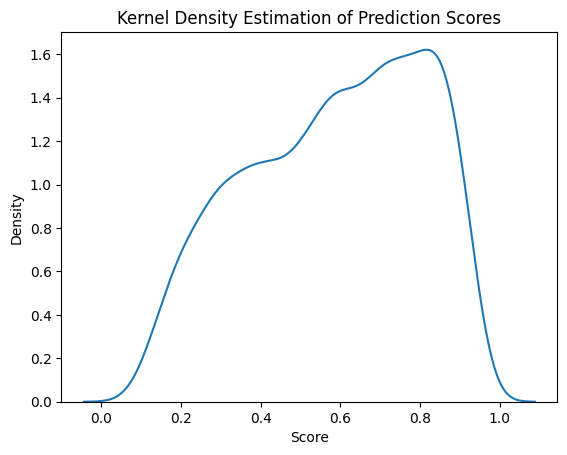

------------------------------------
Best threshold:  0.18719058
Best F1 score:  0.8480901690670006
####################################
XGB model evaluation for question 2
####################################
Training F1 Score: 0.9986703210224961
Validation F1 Score: 0.9854447439353099
Training AUC Score: 0.9986720867208672
Validation AUC Score: 0.5353392586169521


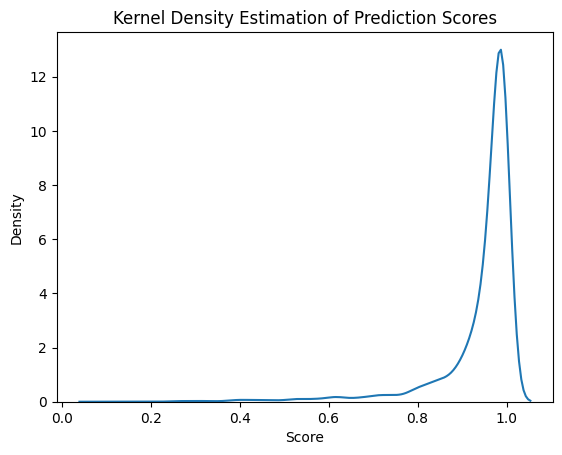

------------------------------------
Best threshold:  0.25776637
Best F1 score:  0.9895956237262683
####################################
XGB model evaluation for question 3
####################################
Training F1 Score: 0.9876443882535486
Validation F1 Score: 0.9371350051528684
Training AUC Score: 0.9877820082968688
Validation AUC Score: 0.5827574594194114


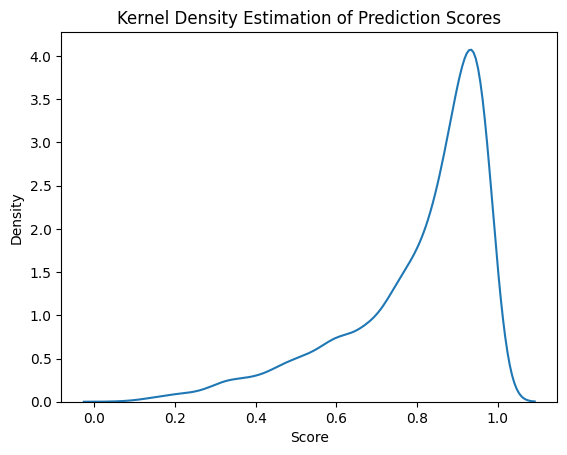

------------------------------------
Best threshold:  0.11976529
Best F1 score:  0.9669992325402916
####################################
XGB model evaluation for question 4
####################################
Training F1 Score: 0.9344583192710091
Validation F1 Score: 0.859341252699784
Training AUC Score: 0.9354044704630123
Validation AUC Score: 0.6818833038637555


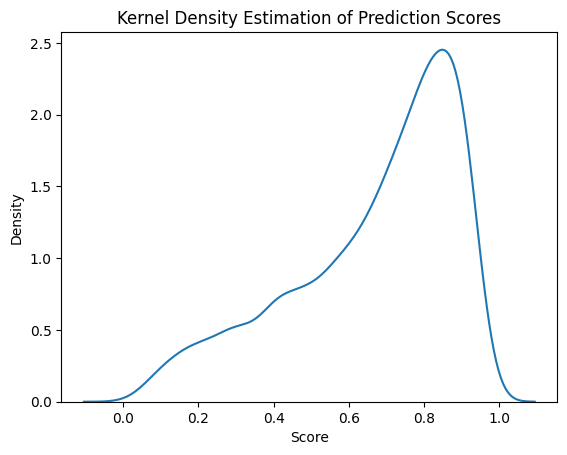

------------------------------------
Best threshold:  0.2598134
Best F1 score:  0.8961373390557941
####################################
XGB model evaluation for question 5
####################################
Training F1 Score: 0.8451486285960462
Validation F1 Score: 0.6674589027530203
Training AUC Score: 0.8430525907238502
Validation AUC Score: 0.6435873714332778


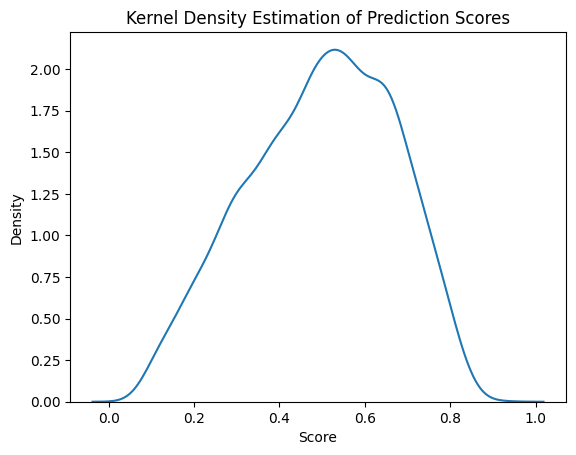

------------------------------------
Best threshold:  0.2930868
Best F1 score:  0.7425041434383004
####################################
XGB model evaluation for question 6
####################################
Training F1 Score: 0.9295288102805029
Validation F1 Score: 0.8294519592804351
Training AUC Score: 0.9304798255179935
Validation AUC Score: 0.6459170682844967


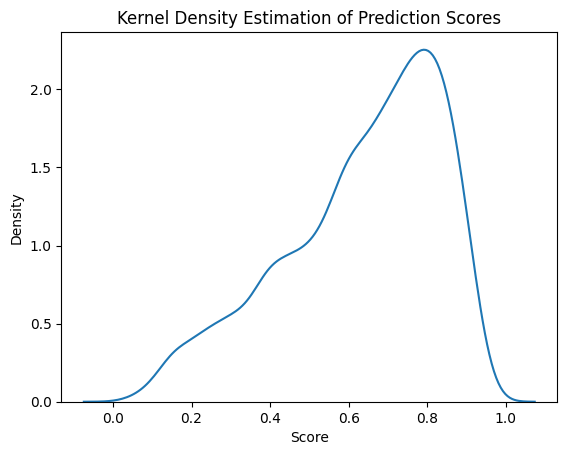

------------------------------------
Best threshold:  0.19913082
Best F1 score:  0.8733015056922512
####################################
XGB model evaluation for question 7
####################################
Training F1 Score: 0.9107311749727174
Validation F1 Score: 0.79701230228471
Training AUC Score: 0.9117012089810016
Validation AUC Score: 0.634027528574198


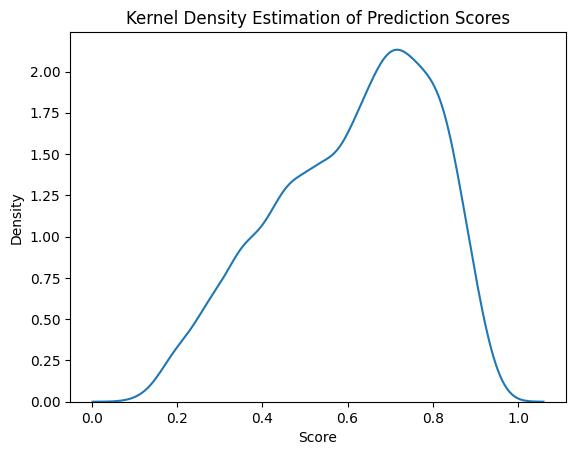

------------------------------------
Best threshold:  0.17841144
Best F1 score:  0.8457943925233644
####################################
XGB model evaluation for question 8
####################################
Training F1 Score: 0.9001321341801287
Validation F1 Score: 0.6629079104732616
Training AUC Score: 0.89907822191592
Validation AUC Score: 0.5554659159938908


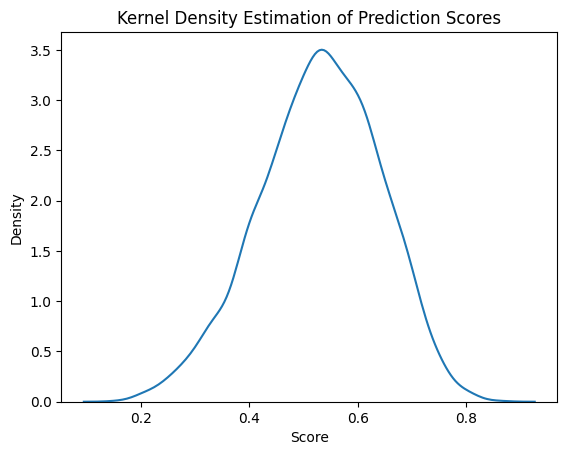

------------------------------------
Best threshold:  0.30029827
Best F1 score:  0.7682489030714003
####################################
XGB model evaluation for question 9
####################################
Training F1 Score: 0.9139508807465548
Validation F1 Score: 0.7860416974715363
Training AUC Score: 0.9142826259277942
Validation AUC Score: 0.6276532817812739


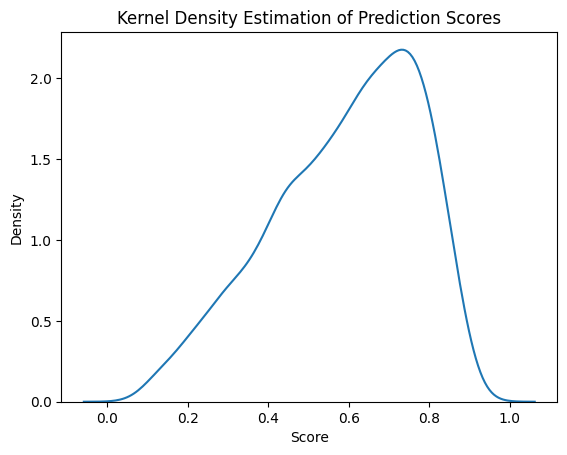

------------------------------------
Best threshold:  0.23203787
Best F1 score:  0.8550670174120005
####################################
XGB model evaluation for question 10
####################################
Training F1 Score: 0.8312960957243797
Validation F1 Score: 0.6235392320534223
Training AUC Score: 0.8279869583508624
Validation AUC Score: 0.6171324772405962


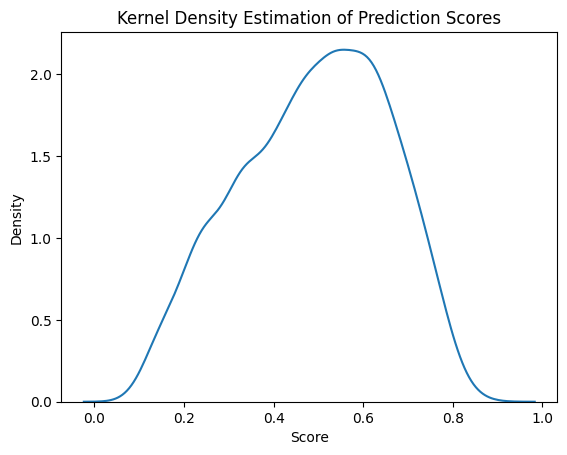

------------------------------------
Best threshold:  0.28309473
Best F1 score:  0.6925336218890091
####################################
XGB model evaluation for question 11
####################################
Training F1 Score: 0.8882133026580666
Validation F1 Score: 0.7341935483870967
Training AUC Score: 0.8876269926488808
Validation AUC Score: 0.6105072327746153


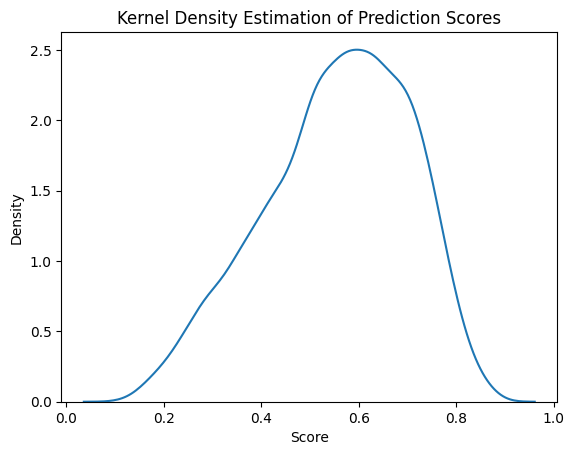

------------------------------------
Best threshold:  0.28556547
Best F1 score:  0.7895296306138719
####################################
XGB model evaluation for question 12
####################################
Training F1 Score: 0.9776140198780072
Validation F1 Score: 0.8948963510728574
Training AUC Score: 0.9777811923786109
Validation AUC Score: 0.5734517881822829


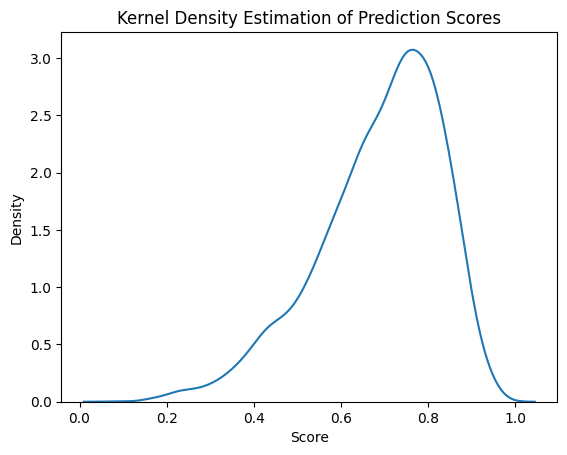

------------------------------------
Best threshold:  0.22679941
Best F1 score:  0.9265730272924518
####################################
XGB model evaluation for question 13
####################################
Training F1 Score: 0.907089579259903
Validation F1 Score: 0.4044943820224719
Training AUC Score: 0.9057102961710886
Validation AUC Score: 0.6073925118192881


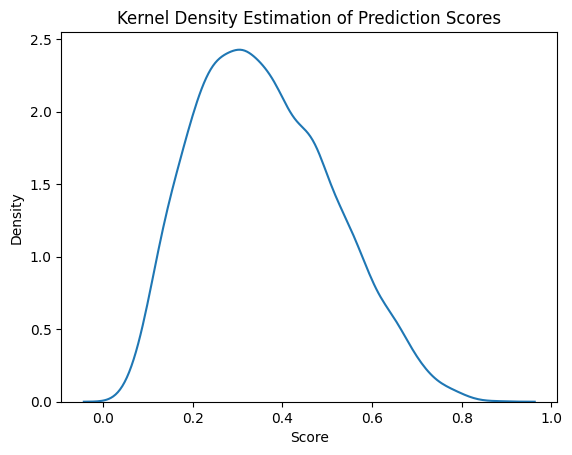

------------------------------------
Best threshold:  0.3086444
Best F1 score:  0.47611940298507455
####################################
XGB model evaluation for question 14
####################################
Training F1 Score: 0.9114256749145796
Validation F1 Score: 0.8014959723820483
Training AUC Score: 0.9113291234400842
Validation AUC Score: 0.6170602222275298


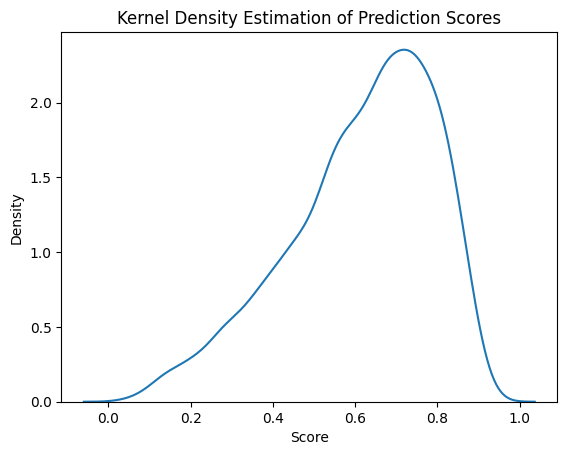

------------------------------------
Best threshold:  0.27337426
Best F1 score:  0.8402397041948234
####################################
XGB model evaluation for question 15
####################################
Training F1 Score: 0.8430604452818963
Validation F1 Score: 0.6669310071371927
Training AUC Score: 0.8382893930104232
Validation AUC Score: 0.6469389709151928


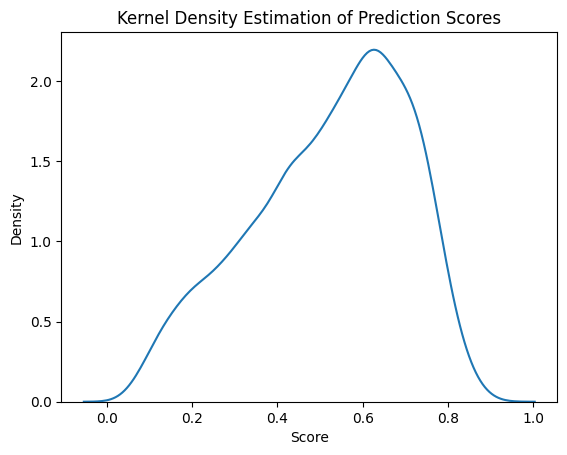

------------------------------------
Best threshold:  0.39314735
Best F1 score:  0.6880165289256198
####################################
XGB model evaluation for question 16
####################################
Training F1 Score: 0.9498149944318712
Validation F1 Score: 0.7907425265188043
Training AUC Score: 0.9494060553382587
Validation AUC Score: 0.5434999133694183


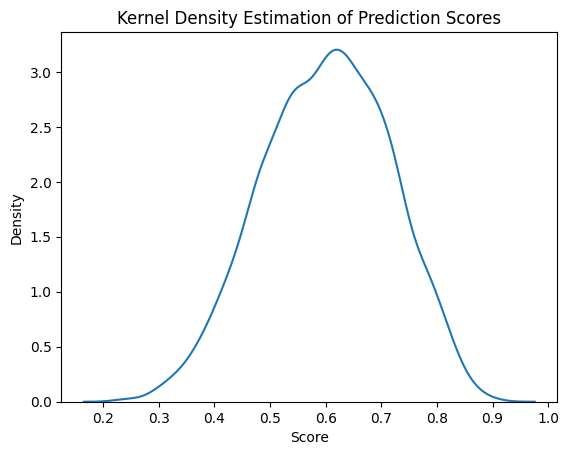

------------------------------------
Best threshold:  0.28757593
Best F1 score:  0.8539079620160701
####################################
XGB model evaluation for question 17
####################################
Training F1 Score: 0.9332721150902968
Validation F1 Score: 0.717663421418637
Training AUC Score: 0.9325651535070761
Validation AUC Score: 0.5506095191582882


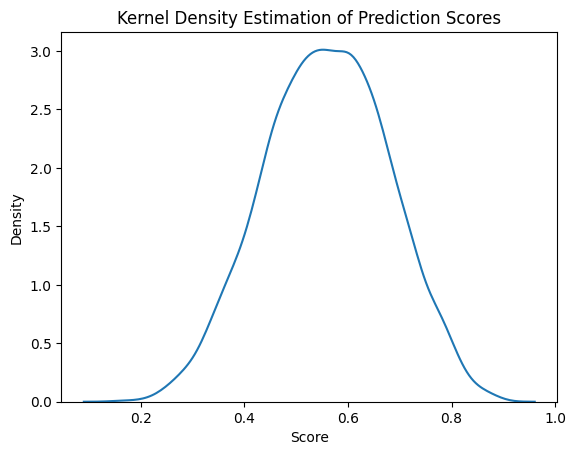

------------------------------------
Best threshold:  0.89421487
Best F1 score:  nan
####################################
XGB model evaluation for question 18
####################################
Training F1 Score: 0.9978478996059141
Validation F1 Score: 0.966861169217219
Training AUC Score: 0.9978525211958946
Validation AUC Score: 0.5344418853548395


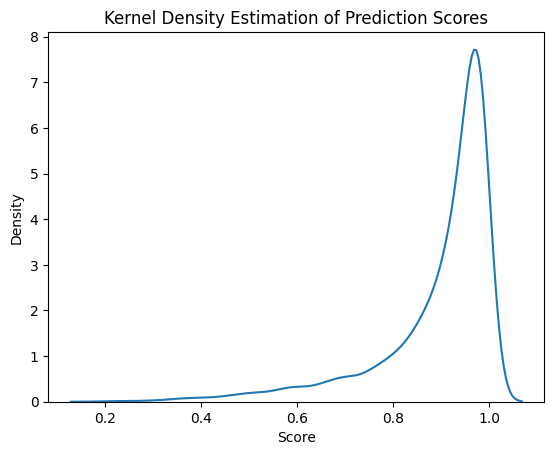

------------------------------------
Best threshold:  0.20289986
Best F1 score:  0.973755853207013
####################################


In [28]:
warnings.filterwarnings("ignore")
targets = pd.read_csv('data/predict-student-performance-from-game-play/train_labels.csv')
targets['session'] = targets.session_id.apply(lambda x: int(x.split('_')[0]))
targets['q'] = targets.session_id.apply(lambda x: int(x.split('_')[-1][1:]))
pred_xgb = np.zeros((df1_features.shape[0],18))     
best_threshold_dict = {}

for t in range(1,19):
    # USE THIS TRAIN DATA WITH THESE QUESTIONS
    if t<=3: 
        grp = '0-4'
        df = df1_features
        df_train = df1_train
        df_valid = df1_valid
        FEATURES = FEATURES1

    elif t<=13: 
        grp = '5-12'
        df = df2_features
        df_train = df2_train
        df_valid = df2_valid
        FEATURES = FEATURES2

    elif t<=22: 
        grp = '13-22'
        df = df3_features
        df_train = df3_train
        df_valid = df3_valid
        FEATURES = FEATURES3
        
    #xgb_params['n_estimators'] =300 #estimators_xgb[t-1]
    #xgb_params = best_params_dict[t]
     
    # TRAIN DATA
    train_users = df_train.index.values
    train_y = targets.loc[targets.q==t].set_index('session').loc[train_users]

    # Validation DATA
    valid_users = df_valid.index.values.astype('int')
    valid_y = targets.loc[targets.q==t].set_index('session').loc[valid_users]

    
    X_train = df_train[FEATURES].astype('float32').fillna(-1)
    y_train = train_y['correct']

    # Use RandomOverSampler instead of SMOTE
    oversampler = RandomOverSampler(random_state=42)
    X_train, y_train = oversampler.fit_resample(X_train, y_train)


    # smote = SMOTE(random_state=42)
    # X_train, y_train = smote.fit_resample(X_train, train_y['correct'])

    clf =  XGBClassifier(**xgb_params)
    clf.fit(X_train, y_train, verbose = 0)
    # clf.save_model(f'XG_boost_models/230607/XGB_question{t}.xgb')
    # print(f'model XGB saved for question {t} with iterations = {estimators_xgb[t-1]}')


    

    #Evaluating the model
    print(f'XGB model evaluation for question {t}')
    

    print(f'####################################')

    # Variables
    #X_train = df_train[FEATURES].astype('float32')
    X_val = df_valid[FEATURES].astype('float32')
    #y_train = train_y['correct']
    y_val = valid_y['correct']

    X = df[FEATURES].astype('float32').fillna(-1)
    train_users = df.index.values
    y = targets.loc[targets.q==t].set_index('session').loc[train_users]['correct']

    # Make predictions
    y_train_preds = clf.predict(X_train)
    y_val_preds = clf.predict(X_val)

    # Calculate metrics
    # train_accuracy = accuracy_score(y_train, y_train_preds)
    # val_accuracy = accuracy_score(y_val, y_val_preds)

    # train_precision = precision_score(y_train, y_train_preds)
    # val_precision = precision_score(y_val, y_val_preds)

    # train_recall = recall_score(y_train, y_train_preds)
    # val_recall = recall_score(y_val, y_val_preds)

    train_f1 = f1_score(y_train, y_train_preds)
    val_f1 = f1_score(y_val, y_val_preds)

    train_auc = roc_auc_score(y_train, y_train_preds)
    val_auc = roc_auc_score(y_val, y_val_preds)

    # Print metrics
    # print(f"Training Accuracy: {train_accuracy}")
    # print(f"Validation Accuracy: {val_accuracy}")
    # print(f"Training Precision: {train_precision}")
    # print(f"Validation Precision: {val_precision}")
    # print(f"Training Recall: {train_recall}")
    # print(f"Validation Recall: {val_recall}")
    print(f"Training F1 Score: {train_f1}")
    print(f"Validation F1 Score: {val_f1}")
    print(f"Training AUC Score: {train_auc}")
    print(f"Validation AUC Score: {val_auc}")

    # Predict probabilities
    y_scores = clf.predict_proba(X_val)[:, 1]

    sns.kdeplot(y_scores)
    plt.xlabel('Score')
    plt.ylabel('Density')
    plt.title('Kernel Density Estimation of Prediction Scores')
    plt.show()

    # Calculate precision-recall values for different thresholds
    precisions, recalls, thresholds = precision_recall_curve(y_val, y_scores)

    # Calculate F1 score for each threshold
    f1_scores = 2*recalls*precisions / (recalls+precisions)

    # Locate the index of the largest F1 score
    best_index = np.argmax(f1_scores)

    # Find the best threshold and corresponding F1 score
    best_threshold = thresholds[best_index]
    best_f1 = f1_scores[best_index]

    best_threshold_dict[t] = best_threshold
    
    print(f'------------------------------------')
    print('Best threshold: ', best_threshold)
    print('Best F1 score: ', best_f1)

    print(f'####################################')

In [18]:
clf.predict_proba(X_val)#[:, 1]

array([[0.2555908 , 0.7444092 ],
       [0.03285676, 0.96714324],
       [0.12858182, 0.8714182 ],
       ...,
       [0.09750646, 0.90249354],
       [0.20846117, 0.79153883],
       [0.24997097, 0.750029  ]], dtype=float32)

In [23]:
# # 
# best_threshold_dict[17] = 0.5

In [24]:
with open('best_threshold.pkl', 'wb') as f:
    pickle.dump(best_threshold_dict, f)

print('Best threshold saved to best_threshold.pkl')

Best threshold saved to best_threshold.pkl


### Defining threshold

In [25]:
best_threshold_dict

{1: 0.22027658,
 2: 0.19263336,
 3: 0.14999242,
 4: 0.18099336,
 5: 0.35882744,
 6: 0.22102284,
 7: 0.23189737,
 8: 0.27159232,
 9: 0.2523853,
 10: 0.32785916,
 11: 0.2775828,
 12: 0.16329089,
 13: 0.2952541,
 14: 0.24339944,
 15: 0.37394908,
 16: 0.22454053,
 17: 0.5,
 18: 0.19002078}

In [29]:
#CV threshholds
best_threshold_dict

{1: 0.18719058,
 2: 0.25776637,
 3: 0.11976529,
 4: 0.2598134,
 5: 0.2930868,
 6: 0.19913082,
 7: 0.17841144,
 8: 0.30029827,
 9: 0.23203787,
 10: 0.28309473,
 11: 0.28556547,
 12: 0.22679941,
 13: 0.3086444,
 14: 0.27337426,
 15: 0.39314735,
 16: 0.28757593,
 17: 0.89421487,
 18: 0.20289986}

# Exporting final models

In [21]:
warnings.filterwarnings("ignore")
targets = pd.read_csv('data/predict-student-performance-from-game-play/train_labels.csv')
targets['session'] = targets.session_id.apply(lambda x: int(x.split('_')[0]))
targets['q'] = targets.session_id.apply(lambda x: int(x.split('_')[-1][1:]))
pred_xgb = np.zeros((df1_features.shape[0],18))     

for t in range(1,19):
    # USE THIS TRAIN DATA WITH THESE QUESTIONS
    if t<=3: 
        grp = '0-4'
        df = df1_features
        FEATURES = FEATURES1

    elif t<=13: 
        grp = '5-12'
        df = df2_features
        FEATURES = FEATURES2

    elif t<=22: 
        grp = '13-22'
        df = df3_features
        FEATURES = FEATURES3
        
    #xgb_params['n_estimators'] =300 #estimators_xgb[t-1]
    #xgb_params = best_params_dict[t]
     
    # TRAIN DATA
    train_users = df.index.values
    train_y = targets.loc[targets.q==t].set_index('session').loc[train_users]

    
    X_train = df[FEATURES].astype('float32').fillna(-1)
    y_train = train_y['correct']

    # Use RandomOverSampler instead of SMOTE
    oversampler = RandomOverSampler(random_state=42)
    X_train, y_train = oversampler.fit_resample(X_train, y_train)

    # #SMOTE
    # smote = SMOTE(random_state=42)
    # X_train, y_train = smote.fit_resample(X_train, train_y['correct'])



    clf =  XGBClassifier(**xgb_params)
    clf.fit(X_train, y_train, verbose = 1)
    clf.save_model(f'XG_boost_models/230611/XGB_question{t}.xgb')
    print(f'model XGB saved for question {t}')

model XGB saved for question 1
model XGB saved for question 2
model XGB saved for question 3
model XGB saved for question 4
model XGB saved for question 5
model XGB saved for question 6
model XGB saved for question 7
model XGB saved for question 8
model XGB saved for question 9
model XGB saved for question 10
model XGB saved for question 11
model XGB saved for question 12
model XGB saved for question 13
model XGB saved for question 14
model XGB saved for question 15
model XGB saved for question 16
model XGB saved for question 17
model XGB saved for question 18


# Submission

In [ ]:
import jo_wilder
env = jo_wilder.make_env()
iter_test = env.iter_test()

In [ ]:
limits = {'0-4':(1,4), '5-12':(4,14), '13-22':(14,19)}

count = 0

for (sample_submission, test) in iter_test:
        
        session_id = test.session_id.values[0]
        grp = test.level_group.values[0]
        a,b = limits[grp]
  

        # ------------------- level 0-4 ---------------------------------
        if a == 1:
            FEATURES = FEATURES1
            test = (pl.from_pandas(test)
                  .drop(["fullscreen", "hq", "music"])
                  .with_columns(columns))
            test = feature_engineer_pl(test, grp, use_extra=True, feature_suffix='')
            test = test[FEATURES]
            

        # ------------------- level 5-12 ---------------------------------
        elif a == 4:
            FEATURES = FEATURES2
            test = (pl.from_pandas(test)
                  .drop(["fullscreen", "hq", "music"])
                  .with_columns(columns))
            test = feature_engineer_pl(test, grp, use_extra=True, feature_suffix='')
            test = test[FEATURES]

        # ------------------- level 13-22 ---------------------------------    
        elif a == 14:
            FEATURES = FEATURES3
            test = (pl.from_pandas(test)
                  .drop(["fullscreen", "hq", "music"])
                  .with_columns(columns))
            test = feature_engineer_pl(test, grp, use_extra=True, feature_suffix='')
            test = test[FEATURES]
    
        for t in range(a,b):

            clf = XGBClassifier()
            clf.load_model(f'/kaggle/working/XGB_question{t}.xgb')

            mask = sample_submission.session_id.str.contains(f'q{t}')
            p = clf.predict_proba(test.astype('float32'))[:,1]
            sample_submission.loc[mask,'correct'] = int((p.item())>0.625)  
                
        env.predict(sample_submission)

In [ ]:
pd.read_csv('submission.csv').head(10)

# DEBUG

### Usefull when you make updates

In [ ]:
"""
test = pd.read_csv('/kaggle/input/predict-student-performance-from-game-play/test.csv')
test = test.drop('session_level', axis=1)
test_level1 = test[test['level_group'] == '0-4']
test_level2 = test[test['level_group'] == '5-12']
test_level3 = test[test['level_group'] == '13-22']
sample_submission = pd.read_csv('/kaggle/input/predict-student-performance-from-game-play/sample_submission.csv')

limits = {'0-4':(1,4), '5-12':(4,14), '13-22':(14,19)}


for test_level in [test_level1,test_level2,test_level3]:
    l = np.unique(test_level['level_group']).tolist()
    print(f'\n***************** level = {l}*******************\n')
    for session_id in [20090109393214576,20090312143683264,20090312331414616]:
        print(f'--------- {session_id} ---------')
        
        test_level_session = test_level[test_level['session_id']==session_id]          
        #display(test_level_session.head(2))
        #------------------------------------
        #grp = test.level_group.values[0]
        grp = l[0] 
        a,b = limits[grp]
        #------------------------------------           
        columns = [

            pl.col("page").cast(pl.Float32),
            (
                (pl.col("elapsed_time") - pl.col("elapsed_time").shift(1)) 
                 .fill_null(0)
                 .clip(0, 1e9)
                 .over(["session_id", "level_group"])
                 .alias("elapsed_time_diff")
            ),
            (
                (pl.col("screen_coor_x") - pl.col("screen_coor_x").shift(1)) 
                 .abs()
                 .over(["session_id", "level_group"])
                .alias("location_x_diff") 
            ),
            (
                (pl.col("screen_coor_y") - pl.col("screen_coor_y").shift(1)) 
                 .abs()
                 .over(["session_id", "level_group"])
                .alias("location_y_diff") 
            ),
            pl.col("fqid").fill_null("fqid_None"),
            pl.col("text_fqid").fill_null("text_fqid_None")
        ]

        # ------------------- level 0-4 ---------------------------------
        if a == 1:
            print('GRP =',grp)
            FEATURES = FEATURES1
            
            test = (pl.from_pandas(test_level.drop(["fullscreen", "hq", "music"],axis=1))
                  .with_columns(columns))
            test = feature_engineer_pl(test, grp, use_extra=True, feature_suffix='')
            test = test[FEATURES]
            test = test.fillna(-1)
            level = 3
            w = 0
            print('test shape',test_level.shape)
            print('level =',level)
          
            scaler = scaler_0

        # ------------------- level 5-12 ---------------------------------
        elif a == 4:
            print('GRP =',grp)
            FEATURES = FEATURES2
            test = (pl.from_pandas(test_level.drop(["fullscreen", "hq", "music"],axis=1))
                  .with_columns(columns))
            test = feature_engineer_pl(test, grp, use_extra=True, feature_suffix='')
            test = test[FEATURES]
            test = test.fillna(-1)
            print('test shape',test.shape) # **********************
            level = 10 
            print('level =',level)
            scaler = scaler_1

        # ------------------- level 13-22 ---------------------------------    
        elif a == 14:
            print('GRP =',grp)
            FEATURES = FEATURES3
            test = (pl.from_pandas(test_level.drop(["fullscreen", "hq", "music"],axis=1))
                  .with_columns(columns))
            test = feature_engineer_pl(test, grp, use_extra=True, feature_suffix='')
            test = test[FEATURES]
            test = test.fillna(-1)
            print('test shape',test.shape) # **********************
            
            level = 5
            print('level =',level)
            scaler = scaler_2
         

        # ---------- Predictions for the session_id and the level_group -------------    

        X_test = scaler.transform(test)
        #X_test = scaler.transform(test)
        
        X_test = torch.from_numpy(X_test.astype(np.float32))
        pred_test = np.zeros((X_test.shape[0],level))

        for i in range(N_SPLITS) :
            with torch.no_grad():
                model = dict_level[level][i]
                model.eval()
                pred = model(X_test.float())
                pred_test += pred.numpy()/N_SPLITS
               
      
        pred_test = pred_test.tolist()[0]
        print(pred_test)           
            
        for t in range(a,b):
            w = t-a
            print(f'---------- t = {t} ----  t-a = {w} -------------')
            mask = sample_submission.session_id.str.contains(f'q{t}')
            sample_submission.loc[mask,'correct'] = int(pred_test[w]>0.61) 
            print('prediction = ',int(pred_test[w]>0.61))                  
           
        #env.predict(sample_submission)
           
"""